# Exercises with Solutions

## Chapter 1: Basics and Linear Models

### Exercise on linear regression

As alternative to the multiple linear regression on diamond prices with logarithmic price and logarithmic carat, consider the same model without logarithms. Interpret the output of the model. Does it make sense from a practical perspective?

In [3]:
# Via scikit-learn
from plotnine.data import diamonds
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse

y = diamonds["price"]
cat_vars = ["color", "cut", "clarity"]
lvl = [diamonds[x].cat.categories.to_numpy() for x in cat_vars]

model = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("linear", "passthrough", ["carat"]),
            ("dummies", OneHotEncoder(categories=lvl, drop="first"), cat_vars)
        ],
        verbose_feature_names_out=False
    ),
    LinearRegression()
)
model.fit(diamonds, y)

print(f"RMSE: {mse(y, model.predict(diamonds), squared=False):.3f}")
print(f"R-squared: {model.score(diamonds, y):.2%}")
print("Intercept", model[-1].intercept_)

feature_names = model[:-1].get_feature_names_out()
results = pd.DataFrame(
    model[-1].coef_,
    columns=["Estimates"],
    index=feature_names
)
results

RMSE: 1156.648
R-squared: 91.59%
Intercept -7362.802156301801


,Estimates
carat,8886.128883
color_E,-211.682481
color_F,-303.310033
color_G,-506.199536
color_H,-978.697665
color_I,-1440.301902
color_J,-2325.222360
cut_Good,655.767448
cut_Very Good,848.716878
cut_Premium,869.395903


In [ ]:
# Via statsmodels
from plotnine.data import diamonds
from statsmodels.formula.api import ols

model2 = ols("price ~ carat + color + cut + clarity", data=diamonds)
results2 = model2.fit()
results2.summary()

**Comments**

- **Model quality:** About 92% of price variations are explained by covariates.
 Typical prediction error is 1157 USD.
- **Effects:** All effects point into the intuitively right direction
 (larger stones are more expensive, worse color are less expensive etc.)
- **Practical perspective:** Additivity in color, cut and clarity are not 
 making sense. Their effects should get larger with larger diamond size. 
 This can be solved by adding interaction terms with carat or, much easier,
 to switch to a logarithmic response.

### Exercise on GLMs

Fit a Gamma regression with log-link to explain diamond prices by `log(carat)`, `color`, `cut`, and `clarity`. Compare the coefficients with those from the corresponding linear regression with `log(price)` as response. Use dummy coding for the three categorical variables.

In [ ]:
from plotnine.data import diamonds
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.glm(
    "price ~ np.log(carat) + color + cut + clarity", data=diamonds, 
    family=sm.families.Gamma(sm.families.links.log())
)
result = model.fit()
result.summary()

bias = diamonds["price"].mean() / result.predict(diamonds).mean() - 1
print(f"Relative bias on USD scale: {bias:.3%}")

**Comment:** The coefficients are very similar to the linear regression with
 log(price) as response. This makes sense, in the end we interpret the 
 coefficients in the same way! The bias is only 0.3%, i.e. much smaller
 than the 3% of the OLS with log(price) as response. Still, because
 log is not the natural link of the Gamma regression, it is not exactly 0.

## Chapter 2: Model Selection and Validation

### Exercise 1

Apply *stratified* splitting (on the response `price`) throughout the 
last example. Do the results change?

**Comment:** The CV results are slightly better and the test performance is clearly worse. Both might be by chance.

### Exercise 2

Regarding the problem that some diamonds seem to appear multiple times in 
the data: As an alternative to *grouped* splitting, repeat the last example 
also on data deduplicated by `price` and all covariates. Do the results change? 
Do you think these results are overly pessimistic?

**Comments:** The test performance of the best model (5-nn) seems clearly worse than the one
without deduplication (~700 USD RMSE vs ~600). CV performance well corresponds to test performance.
Overall, this is probably the more realistic performance than the one obtained from the original data set.
Still, as certain rows could be identical by chance, our deduplication approach might be slightly too conservative.
The true performance will probably be somewhere between the two approaches.

### Exercise 3

Use cross-validation to select the best polynomial degree to represent 
`log(carat)` in the Gamma GLM with log-link (with additional covariates 
`color`, `cut`, and `clarity`). Evaluate the result on an independent 
test data.

**Comments:** The optimal degree seems to be 8 with a CV deviance of 0.01575.
There seems to be some amount of CV overfit as the deviance evaluated on 
the test data is worse.

### Exercise 4

Optional: Compare the linear regression for `price` (using `log(carat)`, 
`color`, `cut`, and `clarity` as covariates) with a corresponding Gamma GLM 
with log-link by simple validation. Use once (R)MSE for comparison and once 
Gamma deviance. 

What do you observe? -> solution not shown here

## Chapter 3: Trees

### Exercises on Random Forests

### Exercise 1

In above example, replace carat by its logarithm. Do the results change 
compared to the example without logs?

**Comment:** The results are essentially identical because log is a monotonic trafo.
Differences might come from implementation tricks of ranger.

### Exercise 2

Fit a random forest on the claims data, predicting the binary variable `clm` 
by the covariates `veh_value`, `veh_body`, `veh_age`, `gender`, `area`, 
and `agecat`. Choose a suitable tree-depth by maximizing OOB error on the 
training data. Make sure to fit a *probability random forest*, i.e. 
predicting probabilities, not classes. Additionally, make sure to work with 
a relevant loss function (information/cross-entropy or Gini gain). 
Use a simple train/test split. Interpret the results by split gain importance 
and partial dependence plots.

**Comment:** Test performance with small tree depth 5 seem to be best
according to OOB results. When studying relative performance metrics
like the relative deviance gain, we can see that performance of the 
model is very low. TPL claims seem to be mostly determined by bad luck,
which makes sense.

## Exercises on Boosting

### Exercise 1

Study the documentation of XGBoost to figure out how to make the model 
monotonically increasing in carat. 
Test your insights without rerunning the grid search in our last example,
i.e. just be refitting the final model. 
How does the partial dependence plot for `carat` look now?

**Comment:** The argument is called "monotone_constraints". For each covariate,
a value 0 means no constraint, a value -1 means a negative constraints,
and a value 1 means positive constraint. Applying the constraint now leads
to a monotonically increasing partial dependence plot. This is extremely
useful in practice. Besides monotonic constraints, also interaction 
constraints are possible.

### Exercise 2

Develop a strong XGBoost model for the claims data set with binary response 
`clm` and covariates `veh_value`, `veh_body`, `veh_age`, `gender`, `area`, 
and `agecat`. Use a clean cross-validation/test approach. 
Use log loss both as objective and evaluation metric. Interpret its results.

## Chapter 4: Neural Nets

### Exercise 1

Fit diamond prices by gamma deviance loss with log-link (i.e. exponential 
output activation), using the custom loss function defined below. Tune the 
model by simple validation and evaluate it on an independent test data set.
Interpret the final model. (Hints: I used a smaller learning rate 
and had to replace the "relu" activations by "tanh". Furthermore, the 
response needed to be transformed from int to float32)

Epoch 1/1000
108/108 [==============================] - 0s 3ms/step - loss: 1805.6743 - val_loss: 757.8267
Epoch 2/1000
108/108 [==============================] - 0s 1ms/step - loss: 358.9893 - val_loss: 146.4827
Epoch 3/1000
108/108 [==============================] - 0s 1ms/step - loss: 89.6860 - val_loss: 54.8963
Epoch 4/1000
108/108 [==============================] - 0s 1ms/step - loss: 39.9848 - val_loss: 29.1300
Epoch 5/1000
108/108 [==============================] - 0s 1ms/step - loss: 23.0544 - val_loss: 18.2368
Epoch 6/1000
108/108 [==============================] - 0s 1ms/step - loss: 15.1290 - val_loss: 12.5481
Epoch 7/1000
108/108 [==============================] - 0s 1ms/step - loss: 10.7384 - val_loss: 9.1916
Epoch 8/1000
108/108 [==============================] - 0s 1ms/step - loss: 8.0418 - val_loss: 7.0382
Epoch 9/1000
108/108 [==============================] - 0s 1ms/step - loss: 6.2653 - val_loss: 5.5804
Epoch 10/1000
108/108 [==============================] - 0s 1ms/

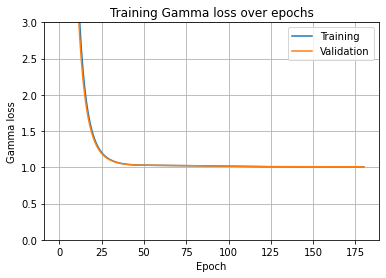

% deviance explained: 98.41%


C:\Users\Michael\anaconda3\envs\ml_lecture\lib\site-packages\dalex\predict_explanations\_ceteris_paribus\checks.py:16: UserWarning:

Variables taken from variables_splits



In [2]:
# Load data and specify preprocessing
from plotnine.data import diamonds
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

diamonds["price"] = diamonds["price"].astype("float32")  # for TensorFlow

ord_features = ["cut", "color", "clarity"]
ord_levels = [
    diamonds[x].cat.categories.to_list() for x in ord_features
]

preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("ordinal", OrdinalEncoder(categories=ord_levels), ord_features),
            ("numeric", "passthrough", ["carat"])
        ]
    ),
    StandardScaler()
)

df_train, df_valid, y_train, y_valid = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=341
)

X_train = preprocessor.fit_transform(df_train)
X_valid = preprocessor.transform(df_valid)

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import RootMeanSquaredError as RMSE
import keras.backend as K

def loss_gamma(y_true, y_pred):
  return -K.log(y_true / y_pred) + y_true / y_pred

inputs = keras.Input(shape=4)
x = layers.Dense(30, activation="tanh")(inputs)
x = layers.Dense(15, activation="tanh")(x)
outputs = layers.Dense(1, activation=K.exp)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss=loss_gamma,
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

cb = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ReduceLROnPlateau(patience=5)
]

tf.random.set_seed(88)
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    batch_size=400, 
    validation_data=(X_valid, y_valid),
    callbacks=cb,
    verbose=1
)

# Training RMSE over epochs
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.gca().set(
    title="Training Gamma loss over epochs",
    xlabel="Epoch",
    ylabel="Gamma loss",
    ylim=(0, 3)
)
plt.grid()
plt.show()

# Interpretation
from sklearn.metrics import mean_gamma_deviance as deviance
from sklearn.dummy import DummyRegressor
import dalex as dx
import plotly
plotly.offline.init_notebook_mode()  # for saving html with plotly plots

dummy = DummyRegressor().fit(X_train, y_train)
d0, d = (deviance(y_valid, m.predict(X_valid)) for m in (dummy, model))
print(f"% deviance explained: {(d0 - d) / d0:.2%}")

def pred_fun(m, X):
    return m.predict(preprocessor.transform(X), batch_size=1000).flatten()

exp = dx.Explainer(
    model, 
    data=df_valid[ord_features + ["carat"]], 
    y=y_valid, 
    predict_function=pred_fun, 
    verbose=False
)

vi = exp.model_parts()
vi.plot()

pdp_num = exp.model_profile(
    type="partial",
    label="Partial depencence for numeric variables",
    variables=["carat"],
    verbose=False
)
pdp_num.plot()

pdp_ord = exp.model_profile(
    type="partial",
    label="Partial depencence for ordinal variables",
    variables=ord_features,
    variable_type="categorical",
    variable_splits=dict(zip(ord_features, ord_levels)),
    verbose=False
)
pdp_ord.plot()


### Exercise 2

Study either the optional claims data example or build your own neural net, 
predicting claim yes/no. For simplicity, you can represent the categorical 
feature `veh_body` by integers.

-> see lecture notes for a solution with embeddings